In [142]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
import csv

import fnmatch
from scipy.io import wavfile
import scipy.io

In [143]:
data_dir = pathlib.Path(r"D:\magistracy\diplom\demo data")
for file in os.listdir(data_dir):
    if fnmatch.fnmatch(file,'*.wav'):
        filename = os.path.join(data_dir, file)
filename         

'D:\\magistracy\\diplom\\demo data\\guitar.wav'

C:\Users\belas\AppData\Local\Temp/ipykernel_10588/3565526111.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _ , waveform = wavfile.read(filename)


(0.0, 1311195.0)

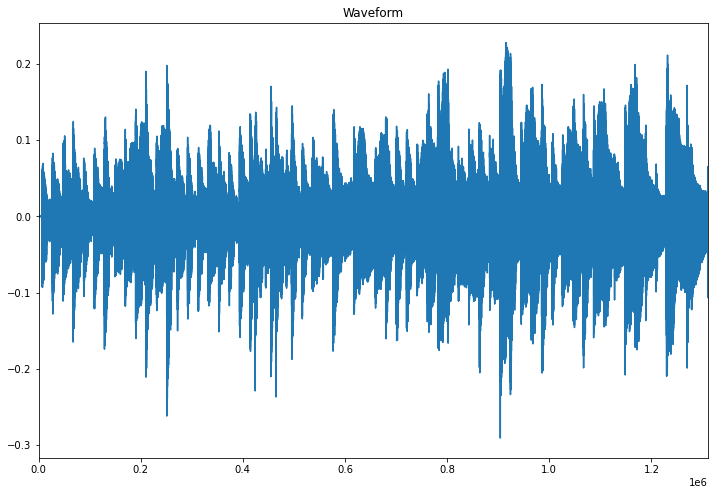

In [144]:
_ , waveform = wavfile.read(filename)
waveform = waveform[:,0]
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot(np.arange(waveform.shape[0]), waveform)
ax.set_title('Waveform')
ax.set_xlim([0, waveform.shape[0]])

In [145]:
model = load_model(r"D:\magistracy\diplom\model\model.h5")


In [146]:
notes = np.array(tf.io.gfile.listdir(str(pathlib.Path(r"D:\magistracy\diplom\records_cut"))))
print('Notes:', notes)


def get_spectrogram(waveform):
    zero_padding = tf.zeros([143326] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)

    spectrogram = tf.signal.stft(equal_length, frame_length=356, frame_step=178,pad_end=True)

    spectrogram = tf.abs(spectrogram)

    return spectrogram


Notes: ['A' 'A#' 'B' 'C' 'C#' 'D' 'D#' 'E' 'F' 'F#' 'G' 'G#']


In [147]:
for file in os.listdir(data_dir):
    if fnmatch.fnmatch(file,'*.csv'):
        filename_csv = os.path.join(data_dir, file)
filename_csv   

'D:\\magistracy\\diplom\\demo data\\guitar.csv'

In [148]:
def freq_distrib(freq):
    note = None
    
    y = np.log(440/freq)/np.log(2**(1/12))
    z = round(y)%12
    if z < 0:
        z += 12 
       
    n = {0: 'A',
         1: 'G#',
         2: 'G',
         3: 'F#',
         4: 'F',
         5: 'E',
         6: 'D#',
         7: 'D',
         8: 'C#',
         9: 'C',
         10: 'B',
         11: 'A#'}
    note = n[z]

    return z, note

In [196]:
time_start = []
time_end = []
pitch = []
notes_real = []
with open(filename_csv) as f:
    reader = csv.reader(f)
    for row in reader:
        time_start.append(row[0])
        time_end.append(row[1])
        pitch.append(row[2][0:len(row[2])-2])  
    time_start = list(map(float,time_start[1:len(time_start)+1]))
    time_end = list(map(float,time_end[1:len(time_end)+1]))
    pitch = list(map(float,pitch[1:len(pitch)+1]))
    for i in range(len(pitch)):
        z, _ = freq_distrib(440*2**((pitch[i]-69)/12))
        notes_real.append((time_start[i],time_end[i],z))
                           
notes_real

[(0.146, 0.613, 9),
 (0.616, 1.072, 7),
 (1.075, 1.536, 5),
 (1.54, 1.982, 7),
 (1.985, 2.461, 9),
 (2.465, 2.916, 10),
 (2.92, 3.402, 9),
 (3.407, 3.85, 2),
 (3.85, 4.297, 0),
 (4.305, 4.772, 0),
 (4.786, 5.223, 7),
 (5.226, 5.691, 0),
 (5.695, 6.152, 9),
 (6.155, 6.615, 7),
 (6.619, 7.076, 9),
 (7.08, 7.518, 10),
 (7.524, 7.998, 5),
 (8.001, 8.461, 7),
 (8.465, 8.914, 9),
 (8.917, 9.378, 10),
 (9.382, 9.613, 7),
 (9.617, 9.846, 9),
 (9.85, 10.075, 10),
 (10.079, 10.312, 0),
 (10.316, 10.537, 7),
 (10.54, 10.769, 9),
 (10.773, 10.998, 10),
 (11.002, 11.202, 0),
 (11.207, 11.691, 9),
 (11.695, 12.152, 10),
 (12.157, 12.647, 1),
 (12.654, 13.062, 5),
 (13.066, 13.998, 10),
 (14.002, 14.954, 0),
 (14.958, 15.412, 0),
 (15.416, 15.869, 10),
 (15.872, 16.335, 8),
 (16.339, 16.796, 10),
 (16.801, 17.204, 0),
 (17.208, 17.723, 1),
 (17.727, 18.24, 0),
 (18.25, 18.659, 5),
 (18.665, 19.101, 3),
 (19.106, 19.567, 3),
 (19.571, 20.047, 10),
 (20.053, 20.495, 3),
 (20.5, 20.982, 0),
 (20.986, 21

In [180]:
L = len(notes_real)
wf_length = waveform.shape[0]
n = int(np.ceil(wf_length/L))

In [181]:
wf_notes = []
for k in range(0,wf_length,n):
    wf = waveform[k:k+n]
    spectrogram = get_spectrogram(wf)
    spectrogram = tf.expand_dims(spectrogram, 0)
    spectrogram = tf.expand_dims(spectrogram, -1)
    prediction = model(spectrogram)
    wf_notes.append((round(k/44100,3),round((k+n)/44100,3),np.argmax(prediction[0])))
wf_notes  

[(0.0, 0.465, 3),
 (0.465, 0.929, 5),
 (0.929, 1.394, 7),
 (1.394, 1.858, 6),
 (1.858, 2.323, 4),
 (2.323, 2.787, 3),
 (2.787, 3.252, 3),
 (3.252, 3.717, 11),
 (3.717, 4.181, 0),
 (4.181, 4.646, 1),
 (4.646, 5.11, 2),
 (5.11, 5.575, 1),
 (5.575, 6.04, 2),
 (6.04, 6.504, 5),
 (6.504, 6.969, 3),
 (6.969, 7.433, 2),
 (7.433, 7.898, 7),
 (7.898, 8.362, 6),
 (8.362, 8.827, 3),
 (8.827, 9.292, 2),
 (9.292, 9.756, 5),
 (9.756, 10.221, 2),
 (10.221, 10.685, 4),
 (10.685, 11.15, 2),
 (11.15, 11.615, 3),
 (11.615, 12.079, 3),
 (12.079, 12.544, 0),
 (12.544, 13.008, 11),
 (13.008, 13.473, 2),
 (13.473, 13.937, 2),
 (13.937, 14.402, 1),
 (14.402, 14.867, 1),
 (14.867, 15.331, 0),
 (15.331, 15.796, 1),
 (15.796, 16.26, 4),
 (16.26, 16.725, 2),
 (16.725, 17.189, 1),
 (17.189, 17.654, 11),
 (17.654, 18.119, 0),
 (18.119, 18.583, 0),
 (18.583, 19.048, 0),
 (19.048, 19.512, 0),
 (19.512, 19.977, 1),
 (19.977, 20.442, 1),
 (20.442, 20.906, 0),
 (20.906, 21.371, 1),
 (21.371, 21.835, 1),
 (21.835, 22.3, 

In [214]:
notes = {0: 'A',
         1: 'G#',
         2: 'G',
         3: 'F#',
         4: 'F',
         5: 'E',
         6: 'D#',
         7: 'D',
         8: 'C#',
         9: 'C',
         10: 'B',
         11: 'A#'}

In [215]:
wf_notes1 = [(x[0],x[1],notes[x[2]]) for x in wf_notes]
wf_notes1[0:10]

[(0.0, 0.465, 'F#'),
 (0.465, 0.929, 'E'),
 (0.929, 1.394, 'D'),
 (1.394, 1.858, 'D#'),
 (1.858, 2.323, 'F'),
 (2.323, 2.787, 'F#'),
 (2.787, 3.252, 'F#'),
 (3.252, 3.717, 'A#'),
 (3.717, 4.181, 'A'),
 (4.181, 4.646, 'G#')]

In [216]:
notes_real1 = [(x[0],x[1],notes[x[2]]) for x in notes_real]
notes_real1[0:10]

[(0.146, 0.613, 'C'),
 (0.616, 1.072, 'D'),
 (1.075, 1.536, 'E'),
 (1.54, 1.982, 'D'),
 (1.985, 2.461, 'C'),
 (2.465, 2.916, 'B'),
 (2.92, 3.402, 'C'),
 (3.407, 3.85, 'G'),
 (3.85, 4.297, 'A'),
 (4.305, 4.772, 'A')]

In [227]:
y_pred = [x[2] for x in wf_notes]
y_true = [x[2] for x in notes_real]
print(y_pred, '\n', y_true)


[3, 5, 7, 6, 4, 3, 3, 11, 0, 1, 2, 1, 2, 5, 3, 2, 7, 6, 3, 2, 5, 2, 4, 2, 3, 3, 0, 11, 2, 2, 1, 1, 0, 1, 4, 2, 1, 11, 0, 0, 0, 0, 1, 1, 0, 1, 1, 11, 3, 2, 1, 11, 2, 1, 0, 1, 1, 0, 9, 9, 11, 11, 1, 11] 
 [9, 7, 5, 7, 9, 10, 9, 2, 0, 0, 7, 0, 9, 7, 9, 10, 5, 7, 9, 10, 7, 9, 10, 0, 7, 9, 10, 0, 9, 10, 1, 5, 10, 0, 0, 10, 8, 10, 0, 1, 0, 5, 3, 3, 10, 3, 0, 10, 0, 1, 8, 10, 0, 1, 10, 0, 1, 3, 0, 1, 4, 8, 1, 3]


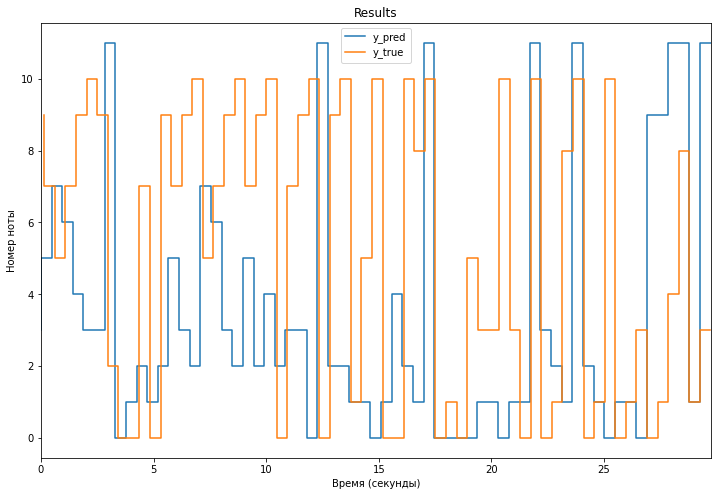

In [230]:
fig, ax = plt.subplots(1, figsize=(12, 8))
timescale1 = np.linspace(wf_notes[0][0],wf_notes[-1][1],num = len(wf_notes))
timescale2 = np.linspace(notes_real[0][0],notes_real[-1][1],num = len(notes_real))
ax.step(timescale1, y_pred)
ax.step(timescale2, y_true)
ax.set_title('Results')
ax.set_xlim([0, max(wf_notes[-1][1], notes_real[-1][1])])
ax.legend(['y_pred','y_true'])
plt.xlabel('Время (секунды)')
plt.ylabel('Номер ноты')
plt.show()

In [231]:
m = tf.keras.metrics.Accuracy()
m.update_state(y_true, y_pred)
m.result().numpy()

0.109375

In [223]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))

precision: 0.09479166666666666
recall: 0.109375


D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [228]:
from sklearn import metrics

print(metrics.classification_report(y_true, y_pred, labels = [0,1,2,3,4,5,6,7,8,9,10,11], digits=3))

              precision    recall  f1-score   support

           0      0.300     0.214     0.250        14
           1      0.267     0.571     0.364         7
           2      0.000     0.000     0.000         1
           3      0.000     0.000     0.000         5
           4      0.000     0.000     0.000         1
           5      0.000     0.000     0.000         4
           6      0.000     0.000     0.000         0
           7      0.000     0.000     0.000         7
           8      0.000     0.000     0.000         3
           9      0.000     0.000     0.000         9
          10      0.000     0.000     0.000        13
          11      0.000     0.000     0.000         0

    accuracy                          0.109        64
   macro avg      0.047     0.065     0.051        64
weighted avg      0.095     0.109     0.094        64



D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Rec